# Tutorial: ML Tools and Techniques

This tutorial explores different tools and techniques for writting your own neural networks. We will cover the following topics:

1. ML overview
    * Types of machine learning: supervised vs unsupervised
    * Types of ML problems: regression vs classification 

2. Key concepts
    * Tensor as data representation
    * Data processing: train-test-split, dataset and dataloader.
    * DNN Layers: input, hidden, activation
    * Loss functions and back propagation.
    * Training and validation loop
    * Hyperparameters: layers, nodes, batch size, epochs, learning rate, ...
    * Performance: loss distribution, ROC curve, ...

3. Tools
    * Pytorch, Pytroch lightning
    * TensorFlow, Keras
    * scikit-learn

4. Example: supervised classification using pytorch

## ML Overview

### Types of machine learning

1. Supervised learning
2. Unsupervised leanring

### Types of problems:

1. Regression
2. Classification

Let's work though some examples to understand loss functions and gradien decent for these two tasks.

## Key concepts

### Tensor as data representation

**Quote**: A torch.Tensor is a multi-dimensional matrix containing elements of a single data type.

In [1]:
import torch
import numpy as np

In [40]:
# Define total number of samples

N1 = 5

# Generate a sample from a normal distribution using numpy.

arr = np.random.normal(0, 1, N1).astype(dtype=np.float32)

# Convert the numpy array to a pytorch tensor

t1 = torch.from_numpy(arr)

# Generate a sample using pytroch directly.

t2 = torch.randn(N1)

In [41]:
arr

array([ 0.33559147,  0.13299221, -0.476214  , -1.9632798 , -0.58815265],
      dtype=float32)

In [42]:
t1

tensor([ 0.3356,  0.1330, -0.4762, -1.9633, -0.5882])

In [43]:
t2

tensor([ 0.9841,  1.4183, -0.1652, -0.7740, -0.4635])

In [44]:
t3 = torch.tensor(arr.astype(np.float32))
t3

tensor([ 0.3356,  0.1330, -0.4762, -1.9633, -0.5882])

In [35]:
# Repeat the above steps for a 2D gaussian and plot the samples

# Define total number of samples

N2 = 500

# Generate a sample from a normal distribution using numpy.

arr = np.random.normal(0, 1, (N2, 2)).astype(dtype=np.float32)

# Convert the numpy array to a pytorch tensor

t1 = torch.from_numpy(arr)

# Generate a sample using pytroch directly.

t2 = torch.randn((N2, 2))

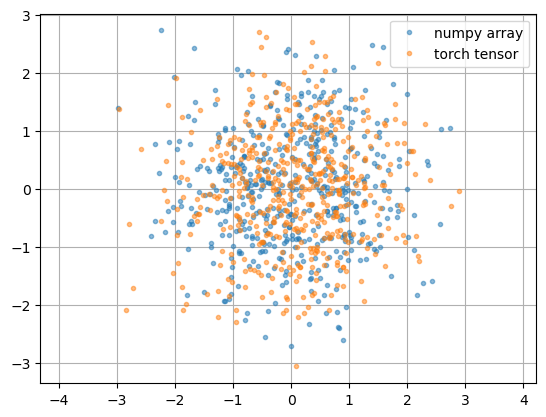

In [36]:
import matplotlib.pyplot as plt
plt.plot(arr[:, 0], arr[:, 1], '.', alpha=0.5, label="numpy array")
plt.plot(t2[:, 0], t2[:, 1], '.', alpha=0.5, label="torch tensor")
plt.axis('equal')
plt.grid()
plt.legend()
plt.show()

In practice, the dataset we use is stored as numpy arrays. We convert the dateset to tensors load them on the GPU.

In [45]:
def np_to_torch(arr):

    return torch.tensor(arr.astype(np.float32))

### Data processing: train-test-split, dataset and dataloader.

The standard way to process data is to fo teh following:

1. Split the input dataset into training and validation sets.
2. Create TensorDataset for training and validation.
2. Create DataLoader for training and validation.

In [47]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [48]:
def process_data(input_x, input_y, batch_size):

    x_train, x_val, y_train, y_val = train_test_split(input_x, input_y, test_size=0.33, random_state=42)

    x_train = np_to_torch(x_train)
    y_train = np_to_torch(y_train)

    x_val = np_to_torch(x_val)
    y_val = np_to_torch(y_val)

    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(x_val, y_val)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, val_dataloader

### DNN Layers: input, hidden, activation

In [50]:
import torch.nn as nn

In [55]:
class Model(nn.Module):
    def __init__(self, 
                 layers,
                 n_inputs,
                 device="cpu"):
        
        super().__init__()
        
        self.layers = []
        for nodes in layers:
            self.layers.append(nn.Linear(n_inputs, nodes))
            self.layers.append(nn.ReLU())
            n_inputs = nodes
        self.layers.append(nn.Linear(n_inputs, 1))
        self.layers.append(nn.Sigmoid())
        self.model_stack = nn.Sequential(*self.layers)
        self.device = device

    def forward(self, x):
        
        return self.model_stack(x)

    def predict(self, x):
        
        with torch.no_grad():
            self.eval()
            x = torch.tensor(x, device=self.device)
            prediction = self.forward(x).detach().cpu().numpy()
        return prediction

### Loss functions and back propagation.

### Training and validation loop

## Example

In [58]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

from tqdm import tqdm
import yaml

In [59]:
class Classifier():
    def __init__(self, 
                 n_inputs,
                 layers=[64,64,64], 
                 learning_rate=1e-3, 
                 loss_type="binary_crossentropy", 
                 device="cpu",
                 outdir="./"):

        self.n_inputs = n_inputs
        self.device = device
        self.model = Model(layers, n_inputs=n_inputs).to(self.device)

        if loss_type == 'binary_crossentropy':
            self.loss_func = F.binary_cross_entropy
        else:
            raise NotImplementedError
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)        
        
        os.makedirs(outdir, exist_ok=True)
        self.outdir = outdir
        
    def np_to_torch(self, array):
    
        return torch.tensor(array.astype(np.float32))
    
    def process_data(self, input_x, input_y, batch_size, weights=None):
        
        if self.n_inputs != input_x.shape[-1]:
            raise RuntimeError(f"input data has {input_x.shape[-1]} features, which doesn't match with number of features!")
        
        if weights is not None:
            x_train, x_val, w_train, w_val, y_train, y_val = train_test_split(input_x, weights, input_y, test_size=0.33, random_state=42)
            w_train = self.np_to_torch(w_train)
            w_val = self.np_to_torch(w_val)
        else:
            x_train, x_val, y_train, y_val = train_test_split(input_x, input_y, test_size=0.33, random_state=42)
        
        x_train = self.np_to_torch(x_train)
        y_train = self.np_to_torch(y_train)
        
        x_val = self.np_to_torch(x_val)
        y_val = self.np_to_torch(y_val)
        
        if weights is not None:
            train_dataset = torch.utils.data.TensorDataset(x_train, w_train, y_train)
            val_dataset = torch.utils.data.TensorDataset(x_val, w_val, y_val)
        else:
            train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
            val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
        
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 8, pin_memory = True)
        val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers = 8, pin_memory = True)
        
        return train_dataloader, val_dataloader
    
    def train(self, input_x, input_y, n_epochs=20, batch_size=512, weights=None, seed=1, min_delta=0.001, save_model=False):
        
        update_epochs = 1
        
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        epochs, epochs_val = [], []
        losses, losses_val = [], []
            
        train_data, val_data = self.process_data(input_x, input_y, weights=weights, batch_size=batch_size)
        
        for epoch in tqdm(range(n_epochs), ascii=' >='):
            
            
            # Training
            
            losses_batch_per_e = []
            
            self.model.train()
            
            for batch_ndx, data in enumerate(train_data):
                
                if weights is not None:
                    batch_inputs, batch_weights, batch_labels = data
                    batch_inputs, batch_weights, batch_labels = batch_inputs.to(self.device), batch_weights.to(self.device), batch_labels.to(self.device)
                else:
                    batch_inputs, batch_labels = data
                    batch_inputs, batch_labels = batch_inputs.to(self.device), batch_labels.to(self.device)
                    batch_weights = None
                
                self.optimizer.zero_grad()
                batch_outputs = self.model(batch_inputs)
                loss = self.loss_func(batch_outputs, batch_labels, weight=batch_weights)
                losses_batch_per_e.append(loss.detach().cpu().numpy())
                mean_loss = np.mean(losses_batch_per_e)
                loss.backward()
                self.optimizer.step()

            epochs.append(epoch)
            losses.append(mean_loss)
            
            
            # Validation
            
            with torch.no_grad():

                self.model.eval()
                val_losses_batch_per_e = []

                for batch_ndx, data in enumerate(val_data):

                    if weights is not None:
                        batch_inputs, batch_weights, batch_labels = data
                        batch_inputs, batch_weights, batch_labels = batch_inputs.to(self.device), batch_weights.to(self.device), batch_labels.to(self.device)
                    else:
                        batch_inputs, batch_labels = data
                        batch_inputs, batch_labels = batch_inputs.to(self.device), batch_labels.to(self.device)
                        batch_weights = None

                    batch_outputs = self.model(batch_inputs)
                    val_loss = self.loss_func(batch_outputs, batch_labels, weight=batch_weights)
                    val_losses_batch_per_e.append(val_loss.detach().cpu().numpy())

                epochs_val.append(epoch)
                mean_val_loss = np.mean(val_losses_batch_per_e)
                losses_val.append(mean_val_loss)

                log.debug(f"Epoch: {epoch} - loss: {mean_loss} - val loss: {mean_val_loss}")
                    
                    
        plt.figure(figsize=(6,4))
        plt.plot(epochs, losses, label="loss")
        plt.plot(epochs_val, losses_val, label="val loss")
        plt.xlabel("number of epochs")
        plt.ylabel("loss")
        plt.legend()
        plt.show
        plt.savefig(f"{self.outdir}/classfier_loss.png")
        plt.close()
        
        if save_model:
            torch.save(self.model, f"{self.outdir}_ep_{epoch}")
    
    def evaluation(self, X_test,y_test=None, weights=None):
        
        self.model.eval()
        
        with torch.no_grad():
            x_test = self.np_to_torch(X_test).to(self.device)
            outputs = self.model(x_test).detach().cpu().numpy()

            # calculate auc 
            if y_test is not None:
                auc = roc_auc_score(y_test, outputs)
                fpr, tpr, _ = roc_curve(y_test, outputs, sample_weight=weights)
                np.save(f"{self.outdir}/fpr.npy", fpr)
                np.save(f"{self.outdir}/tpr.npy", tpr)

        if y_test is not None:
            fig, ax = plt.subplots(1, 1, figsize=(7, 5))
            ax.plot(fpr, tpr, label=f"AUC: {auc:.3f}")
            ax.set_xlabel("FPR")
            ax.set_ylabel("TPR")
            ax.set_title(f"ROC curve")
            ax.plot([0,1],[0,1],color="gray",ls=":",label="Random")
            fname = f"{self.outdir}/roc.png"
            ax.legend()
            fig.savefig(fname)

            if auc < 0.5:
                auc = 1.0 - auc

            print(f"AUC: {auc}.")
            
        return outputs